# Workflow of tracking LNO2

In [1]:
import xarray as xr
import proplot as pplt
from glob import glob
from matplotlib.animation import FuncAnimation

pplt.rc.reso = 'med'

# Disable warnings
from warnings import filterwarnings
filterwarnings("ignore")

## Read S5P-LNO2 product

Data used in this notebook are produced by the [S5P-LNO2](https://github.com/zxdawn/S5P-LNO2) program.

In [2]:
filename = glob('../data/clean_lightning/S5P_PAL__L2__NO2____20190811T00*.nc')[0]

ds_tropomi = xr.open_dataset(filename, group='S5P').isel(time=0)\
                [['nitrogendioxide_tropospheric_column',
                  'nitrogendioxide_segmentation', 'lightning_mask']]

ds_lightning = xr.open_dataset(filename, group='Lightning')

## Transport of lightning tracer

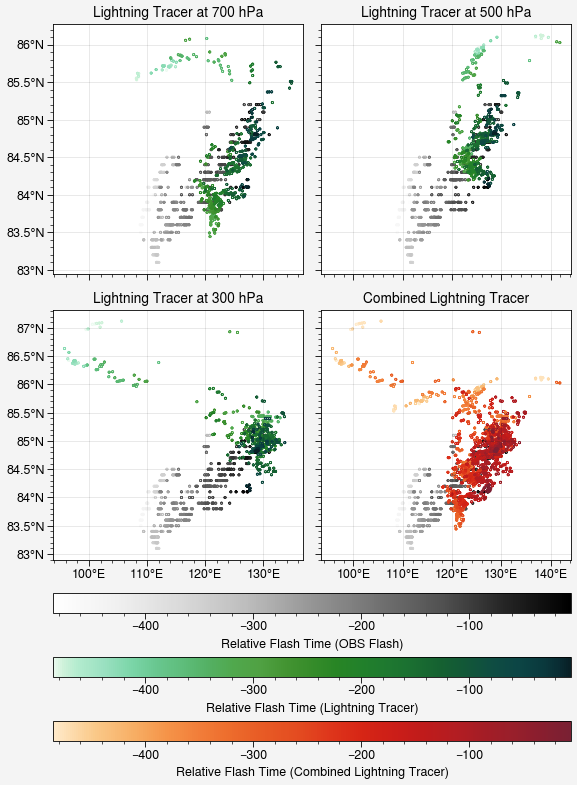

In [3]:
fig, axs = pplt.subplots(nrows=2, ncols=2, span=False, sharey=3, sharex=3)

s_obs = axs.scatter(ds_lightning['longitude'], ds_lightning['latitude'],
                marker="$\u25EF$", cmap='Greys',
                c=ds_lightning['delta'], s=3)

axs[0].scatter(ds_lightning['longitude_pred'].sel(level=700),
               ds_lightning['latitude_pred'].sel(level=700),
               marker="$\u25EF$", cmap='Greens2',
               c=ds_lightning['delta'], s=3)

axs[1].scatter(ds_lightning['longitude_pred'].sel(level=500),
               ds_lightning['latitude_pred'].sel(level=500),
               marker="$\u25EF$", cmap='Greens2',
               c=ds_lightning['delta'], s=3)

s_transport = axs[2].scatter(ds_lightning['longitude_pred'].sel(level=300),
               ds_lightning['latitude_pred'].sel(level=300),
               marker="$\u25EF$", cmap='Greens2',
               c=ds_lightning['delta'], s=3)

for level in ds_lightning.level:
    s_transport_comb = axs[3].scatter(ds_lightning['longitude_pred'].sel(level=level),
                ds_lightning['latitude_pred'].sel(level=level),
                marker="$\u25EF$", cmap='Reds2',
                c=ds_lightning['delta'], s=3)

fig.colorbar(s_obs[0], loc='b', label=f'Relative Flash Time (OBS Flash)')
fig.colorbar(s_transport, loc='b', label=f'Relative Flash Time (Lightning Tracer)')
fig.colorbar(s_transport_comb, loc='b', label=f'Relative Flash Time (Combined Lightning Tracer)')

axs.format(title=['Lightning Tracer at 700 hPa', 'Lightning Tracer at 500 hPa',
                  'Lightning Tracer at 300 hPa', 'Combined Lightning Tracer'],
           xformatter='deglon', yformatter='deglat', xlabel='', ylabel='')

### Animation

In [4]:
fig, ax = pplt.subplots()

# set plot region
lon_min = 95; lon_max = 145
lat_min = 82; lat_max = 88

# plot NO2 background
lon = ds_tropomi['nitrogendioxide_tropospheric_column'].coords['longitude']
lat = ds_tropomi['nitrogendioxide_tropospheric_column'].coords['latitude']

mask = (lon>lon_min) & (lon<lon_max) & (lat>lat_min) & (lat<lat_max)
no2 = ds_tropomi['nitrogendioxide_tropospheric_column']
no2.where(mask, drop=True).plot(ax=ax, x='longitude', y='latitude',
                                cmap='Thermal', vmin=0, vmax=4e-5, discrete=False,
                                cbar_kwargs={'label': '[mol m$^{-2}$]'},
                                alpha=0.8)


# plot OBS lightning
s_obs = ax.scatter(ds_lightning['longitude'], ds_lightning['latitude'],
           marker="$\u25EF$", cmap='Greys',
           c=ds_lightning['delta'], s=3)

def animate(level):
    ax.format(xlim=(lon_min, lon_max), ylim=(lat_min, lat_max), grid=False,
          xformatter='deglon', yformatter='deglat', xlabel='', ylabel='')

    animate.scatter.remove()
    animate.scatter = ax.scatter(ds_lightning['longitude_pred'].sel(level=level),
                ds_lightning['latitude_pred'].sel(level=level),
                marker="$\u25EF$", cmap='Greens2',
                c=ds_lightning['delta'], s=3)

    ax.set_title(f'Lightning Tracer at {level} hPa')

animate.scatter = ax.scatter([], [])

anim = FuncAnimation(fig, animate, interval=1000, frames=ds_lightning.level.values, repeat=True)
anim.save('lightning_tracer_transport.gif', dpi=600)
fig.clf()

Figure(nrows=1, ncols=1, figwidth=3.91, figheight=3.22)

In [5]:
# from IPython.display import HTML
# HTML('<img src="lightning_tracer_transport.gif">')

## Mask NO2

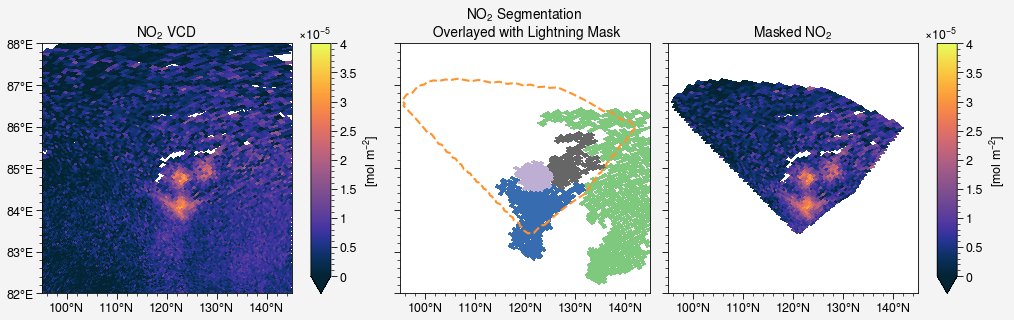

In [6]:
# set plot region
lon_min = 95; lon_max = 145
lat_min = 82; lat_max = 88

fig, axs = pplt.subplots(nrows=1, ncols=3, span=False, sharey=3, sharex=3)

lon = ds_tropomi['nitrogendioxide_tropospheric_column'].coords['longitude']
lat = ds_tropomi['nitrogendioxide_tropospheric_column'].coords['latitude']

mask = (lon>lon_min) & (lon<lon_max) & (lat>lat_min) & (lat<lat_max)
no2 = ds_tropomi['nitrogendioxide_tropospheric_column']
no2.where(mask, drop=True).plot(ax=axs[0], x='longitude', y='latitude',
                                cmap='Thermal', vmin=0, vmax=4e-5, discrete=False,
                                cbar_kwargs={'label': '[mol m$^{-2}$]'})

segmentation = ds_tropomi['nitrogendioxide_segmentation'].where(mask, drop=True)
segmentation.where(segmentation>0).plot(x='longitude', y='latitude', ax=axs[1], cmap='Accent', add_colorbar=False)

# ds_tropomi['lightning_mask'].where(mask, drop=True).plot(ax=axs[2], x='longitude', y='latitude', add_colorbar=False)
axs[1].contour(ds_tropomi['lightning_mask'].longitude, ds_tropomi['lightning_mask'].latitude,
               ds_tropomi['lightning_mask'], levels=[1], colors=['orange5'], ls='--')


no2.where(ds_tropomi['lightning_mask']>0).plot(ax=axs[2], x='longitude', y='latitude',
                                              cmap='Thermal', vmin=0, vmax=4e-5, discrete=False,
                                              cbar_kwargs={'label': '[mol m$^{-2}$]'})


axs[0].format(title='NO$_2$ VCD')
axs[1].format(title='NO$_2$ Segmentation \n Overlayed with Lightning Mask')
axs[2].format(title='Masked NO$_2$')

axs.format(xlim=(lon_min,lon_max), ylim=(lat_min,lat_max),
           xformatter='deglat', yformatter='deglon',
           xlabel='', ylabel='', grid=False)